In [9]:
!nvidia-smi # check if the GPU is available 

Tue Sep 28 13:51:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   31C    P8     9W / 250W |    154MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   

Using TensorFlow backend.


In [1]:
from __future__ import print_function
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" # uncomment if there is GPU
import numpy as np
import keras
from keras.models import *
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator
from keras import layers
import keras.backend as K
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


Using TensorFlow backend.


In [2]:



def one_side_pad(x):
    x = ZeroPadding2D((1, 1))(x)
    x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x



def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):

    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=256,  input_width=256, classes=1000):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

 
    img_input = Input(shape=(input_height, input_width, 3))
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3),strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D(name='avg_pool')(x)
    flatten1 = Flatten()(x)
    
    dense = Dense(units=classes, kernel_initializer="he_normal",activation="softmax")(flatten1)
    model= Model(inputs = img_input, outputs = dense)

    return model









In [3]:
model = get_resnet50_encoder(input_height=256,  input_width=256, classes=5)

In [4]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001, beta_1=0.5)


In [5]:

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])


In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        vertical_flip=True,
        horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        "/home/sami/Vincent/train",
        target_size=(256 , 256),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        '/home/sami/Vincent/pdata/validation',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')



Found 5656 images belonging to 5 classes.
Found 163 images belonging to 5 classes.


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnet50_aug.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history = model.fit_generator(train_generator,steps_per_epoch=2000,epochs=3,callbacks=callbacks,
                              validation_data=validation_generator,validation_steps=800)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('resnet_wo_aug.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history = model.fit_generator(train_generator,steps_per_epoch=2000,epochs=100,callbacks=callbacks,
                              validation_data=validation_generator,validation_steps=800)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/100





2000/2000 [==============================] - 1185s 593ms/step - loss: 1.4086 - acc: 0.5847 - val_loss: 1.4587 - val_acc: 0.4478
Epoch 2/100
2000/2000 [==============================] - 1139s 569ms/step - loss: 0.8135 - acc: 0.7767 - val_loss: 2.1477 - val_acc: 0.4110
Epoch 3/100
2000/2000 [==============================] - 1133s 567ms/step - loss: 0.2053 - acc: 0.9425 - val_loss: 2.1163 - val_acc: 0.5275
Epoch 4/100
2000/2000 [==============================] - 1135s 568ms/step - loss: 0.1460 - acc: 0.9627 - val_loss: 3.3659 - val_acc: 0.3617
Epoch 5/100
2000/2000 [==============================] - 1135s 567ms/step - loss: 0.1394 - acc: 0.9660 - val_loss: 4.5053 - val_acc: 0.4480
Epoch 6/100
2000/2000 [==============================] - 1135s 567ms/step - loss

Epoch 23/100
2000/2000 [==============================] - 1134s 567ms/step - loss: 0.0155 - acc: 0.9942 - val_loss: 4.4050 - val_acc: 0.4538
Epoch 24/100
2000/2000 [==============================] - 1136s 568ms/step - loss: 0.0374 - acc: 0.9890 - val_loss: 4.3628 - val_acc: 0.4539
Epoch 25/100
2000/2000 [==============================] - 1136s 568ms/step - loss: 0.0136 - acc: 0.9950 - val_loss: 4.6773 - val_acc: 0.4540
Epoch 26/100
2000/2000 [==============================] - 1135s 568ms/step - loss: 0.0399 - acc: 0.9894 - val_loss: 4.0443 - val_acc: 0.4048
Epoch 27/100
2000/2000 [==============================] - 1134s 567ms/step - loss: 0.0137 - acc: 0.9950 - val_loss: 4.4722 - val_acc: 0.4109
Epoch 28/100
2000/2000 [==============================] - 1135s 567ms/step - loss: 0.0307 - acc: 0.9905 - val_loss: 4.1755 - val_acc: 0.4112
Epoch 29/100
2000/2000 [==============================] - 1137s 568ms/step - loss: 0.0127 - acc: 0.9951 - val_loss: 4.4376 - val_acc: 0.4479
Epoch 30/100


Epoch 55/100
2000/2000 [==============================] - 1136s 568ms/step - loss: 0.0172 - acc: 0.9939 - val_loss: 4.8622 - val_acc: 0.4663
Epoch 56/100
2000/2000 [==============================] - 1136s 568ms/step - loss: 0.0141 - acc: 0.9947 - val_loss: 4.7254 - val_acc: 0.4415
Epoch 57/100
2000/2000 [==============================] - 1135s 568ms/step - loss: 0.0096 - acc: 0.9958 - val_loss: 5.6059 - val_acc: 0.4417
Epoch 58/100
2000/2000 [==============================] - 1138s 569ms/step - loss: 0.0062 - acc: 0.9969 - val_loss: 5.5053 - val_acc: 0.4417
Epoch 59/100
2000/2000 [==============================] - 1137s 568ms/step - loss: 0.0175 - acc: 0.9943 - val_loss: 4.5799 - val_acc: 0.4664
Epoch 60/100
2000/2000 [==============================] - 1139s 569ms/step - loss: 0.0062 - acc: 0.9967 - val_loss: 4.7519 - val_acc: 0.4725
Epoch 61/100
2000/2000 [==============================] - 1137s 568ms/step - loss: 0.0158 - acc: 0.9945 - val_loss: 4.3296 - val_acc: 0.4417
Epoch 62/100


Epoch 87/100
2000/2000 [==============================] - 1130s 565ms/step - loss: 0.0114 - acc: 0.9967 - val_loss: 4.7584 - val_acc: 0.4603
Epoch 88/100
2000/2000 [==============================] - 1130s 565ms/step - loss: 0.0144 - acc: 0.9961 - val_loss: 7.4663 - val_acc: 0.3251
Epoch 89/100
2000/2000 [==============================] - 1130s 565ms/step - loss: 0.0124 - acc: 0.9960 - val_loss: 4.8291 - val_acc: 0.5093
Epoch 90/100
2000/2000 [==============================] - 1130s 565ms/step - loss: 0.0118 - acc: 0.9958 - val_loss: 4.2698 - val_acc: 0.4969
Epoch 91/100
2000/2000 [==============================] - 1129s 565ms/step - loss: 0.0129 - acc: 0.9959 - val_loss: 4.5065 - val_acc: 0.4907
Epoch 92/100
2000/2000 [==============================] - 1130s 565ms/step - loss: 0.0091 - acc: 0.9968 - val_loss: 4.9043 - val_acc: 0.4662
Epoch 93/100
2000/2000 [==============================] - 1131s 565ms/step - loss: 0.0152 - acc: 0.9954 - val_loss: 5.0466 - val_acc: 0.4602
Epoch 94/100


In [12]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'history_training.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()
plt.savefig(model.name+'_accuracy.png')


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()
plt.savefig(model.name+'_loss.png')

In [19]:
model.load_weights('resnet50_aug.h5')

In [11]:
print(model.evaluate(xtest,ytest))

106/106 [==============================] - 2s 19ms/step
[1.611379639157709, 0.2358490566037736]


In [9]:
pred = model.predict(xtest)

In [12]:
pred1=np.round(pred)

In [15]:
pred1 = np.asarray(pred1)

In [21]:
from sklearn.metrics import confusion_matrix,classification_report
from matplotlib import pyplot as plt
pred = model.predict(xtest)
y_true = np.argmax(ytest, axis=-1)
print("Validation Labels")
ass=np.random.randint(0, high=xtest.shape[0], size=5, dtype=int)
print(y_true[ass])
a = model.predict(xtest)
y_pred = np.argmax(a, axis=-1)
print("Validation Prediction")
print(y_pred[ass])
print('Confusion Matrix')
target_names = ['cbb', 'cbsd','cgm','cmd','healthy'] 
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Validation Labels
[3 3 3 3 1]
Validation Prediction
[3 3 3 3 0]
Confusion Matrix
[[ 4  9  0  1  0]
 [ 3 16  0  2  3]
 [ 0  1  2 16  0]
 [ 1  2  2 19  2]
 [ 3  6  1  7  6]]
Classification Report
              precision    recall  f1-score   support

         cbb       0.36      0.29      0.32        14
        cbsd       0.47      0.67      0.55        24
         cgm       0.40      0.11      0.17        19
         cmd       0.42      0.73      0.54        26
     healthy       0.55      0.26      0.35        23

    accuracy                           0.44       106
   macro avg       0.44      0.41      0.39       106
weighted avg       0.45      0.44      0.40       106



In [23]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('resnet_simple.png',dpi=95,quality=95)
    plt.show()
    

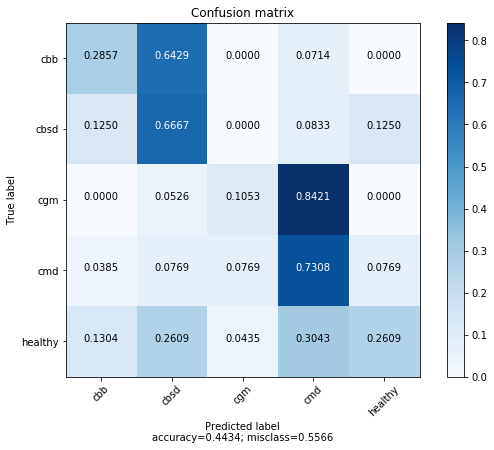

In [24]:
plot_confusion_matrix(cm,labels,title='Confusion matrix',cmap=None,normalize=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()
plt.savefig(model.name+'_accuracy.png')


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()
plt.savefig(model.name+'_loss.png')